# Major Project
## Spill Identification in a Domestic Setting 

## Introduction

Majority of spill analysis research papers fall under two larger categories.

The first is the imaging and identification of ocean oil spills, which is meant to support the preservation of marine life when these accidents happen.(Jha, 2008) (Tysiąc, 2022)

The second is for forensic analysis of blood spatter. This helps improve homicide crime investigation, particularly in recreating or confirming scenarios where blood spatter is involved.(Nirupama, 2024)

Our Project covers spill analysis that happen in the domestic setting, which has minimal research available.
This domain tends to have a lot of variability: There are too many liquid-to-surface combinations involved in spills. The multitude of factors introduced by these combinations create the perfect space for AI imaging systems to fit into.


The applications of our study can be as simple as **cleaning robots** that:
1) Need to use different cloths for water-based or oil-based spills
2) Need to identify and prioritize spills that can stain surfaces

Or, as important as **disaster response robots** that need to:

1) Identify if certain liquids are volatile or safe to traverse
2) Identify if they can pull or drag human bodies across an unavoidable spill safely

## Methodology: 21-Class Data

The data from the project was taken from various surfaces of our own homes, at varying lighting conditions. 21 categories of liquids were chosen at 70 images per class. Below is an example image of the variability of surfaces used to collect this data, from the homes of the group members.

The classes are as follows:  
Alcohol  
Cleaning Agent  
Coffee  
Coke  
Dishwashing Liquid  
Fanta  
Fish Sauce  
Gatorade Blue  
Gatorade Purple  
Gatorade Red  
Gatorade Watermelon  
Glass Cleaner  
Liquid Datergent  
Milk  
Oil  
Red Food Coloring  
Soy Saunce  
Sparkling Water  

These classes are specifically chosen such that an AI system imaging system cannot just use color to identify them. Some classes are differentiated by other factors, like viscosity (liquid's edges), translucence (likeness to the background), or carbonation (bubbles in the liquid). 

The images are collected and split into training, testing, and validation sets, such that each set has an equal number of samples per class. These images are used to fine-tune a pre-trained resnet50 model, with data augmentation, layer-by-layer learning rates, and a 21 class final layer.

Below is a code showing sample images from each class.

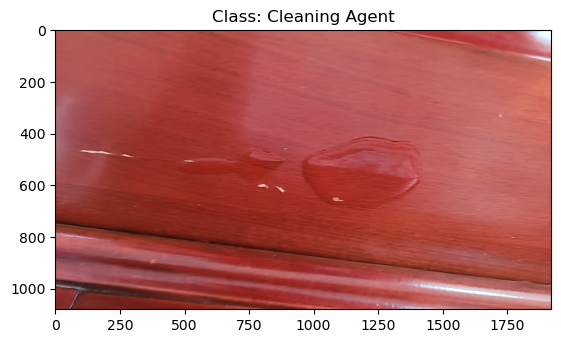

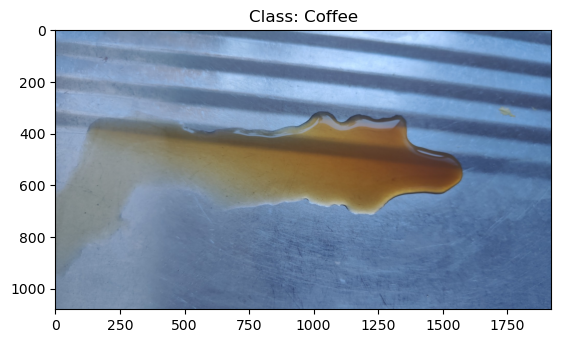

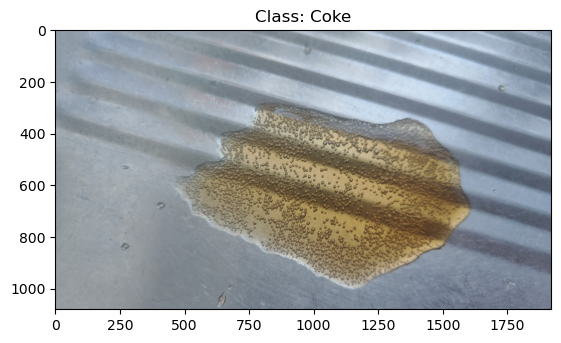

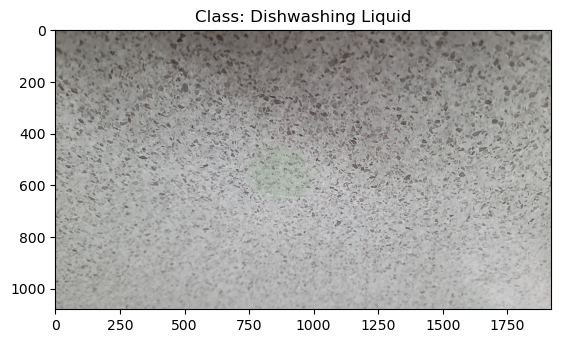

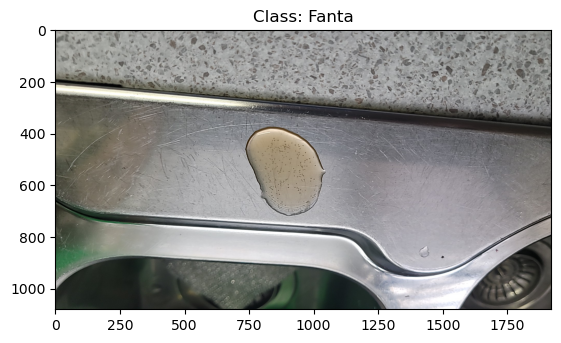

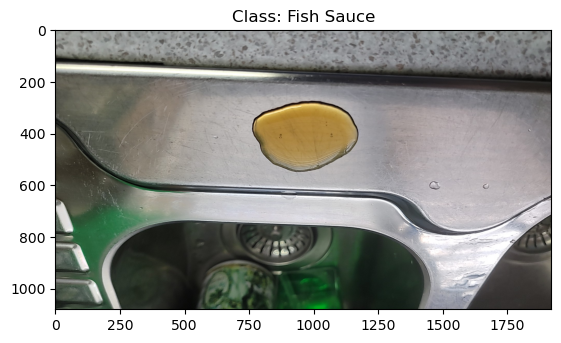

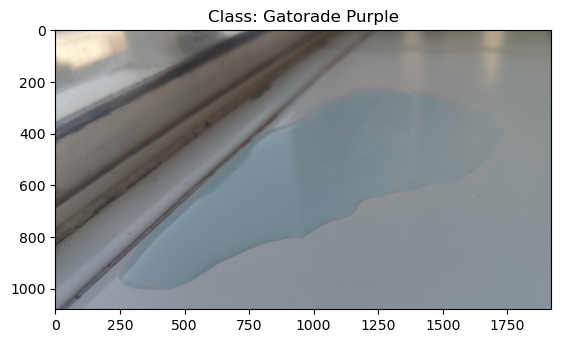

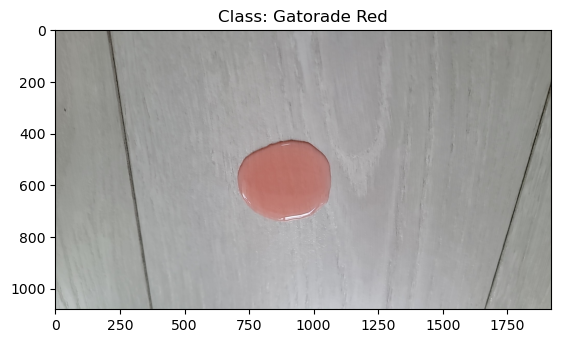

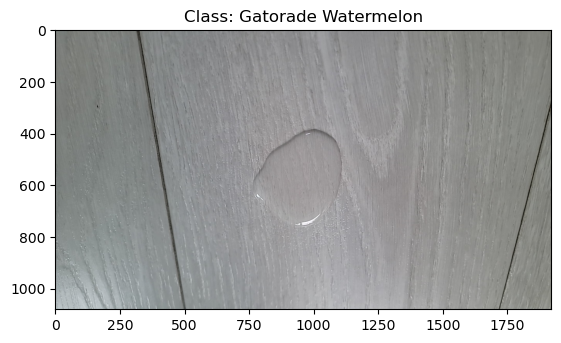

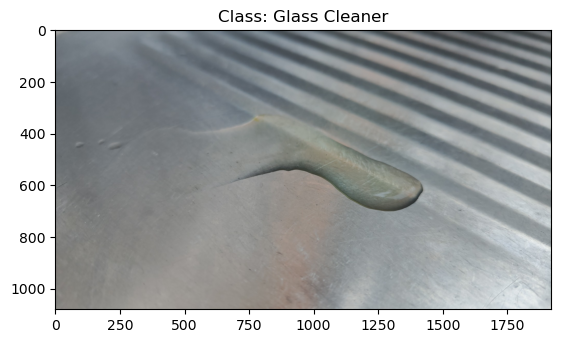

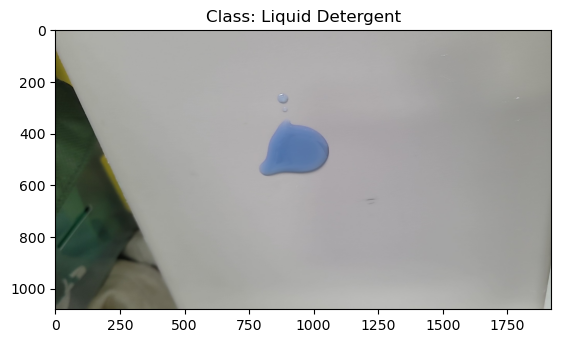

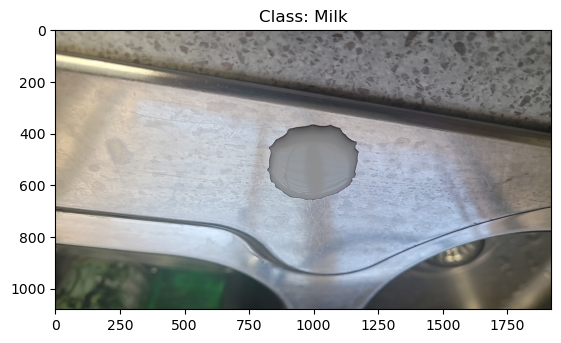

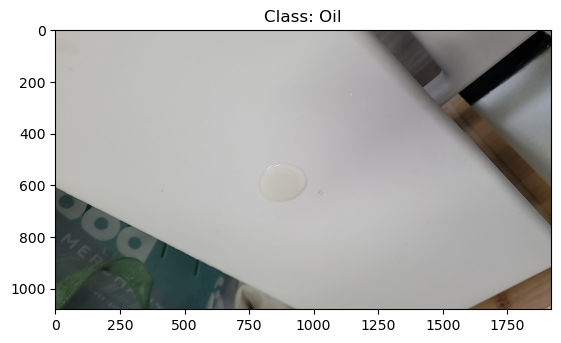

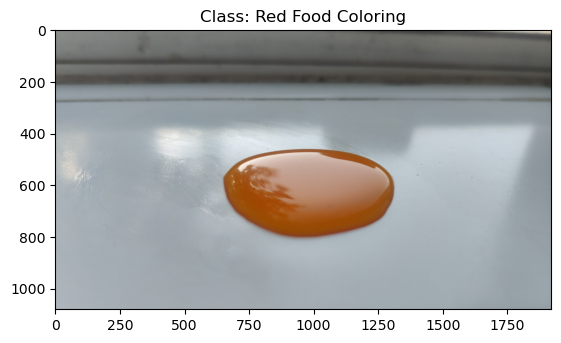

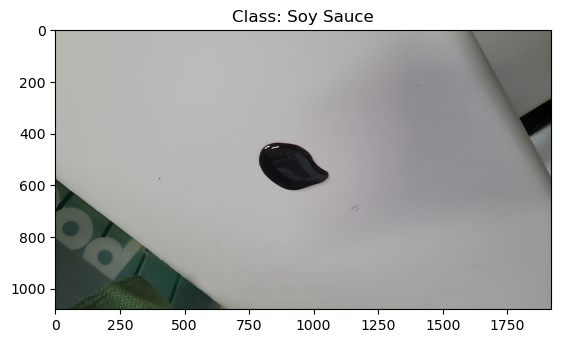

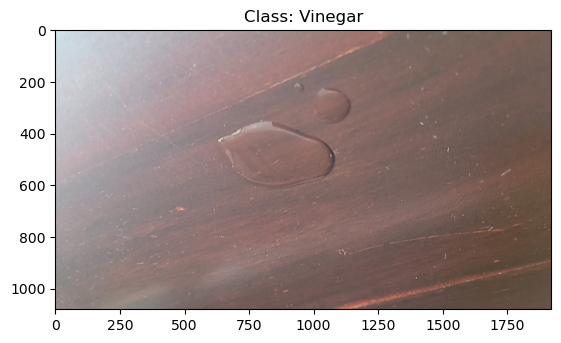

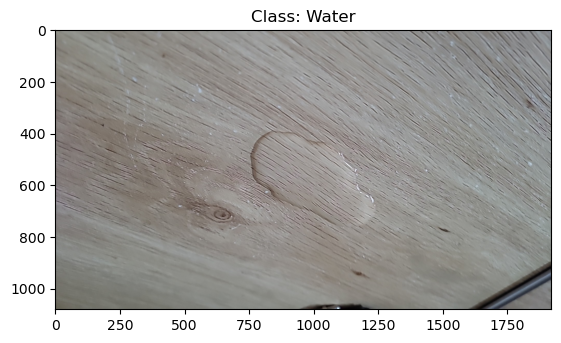

In [10]:
import os
import matplotlib.pyplot as plt
import random
base_folder="Pictures"
classes = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]
num_classes=len(classes)
for cls in classes:
    class_folder = os.path.join(base_folder, cls)
    randomindex=int(random.random()*num_classes)
    img_name=os.listdir(class_folder)[randomindex]
    image=plt.imread(os.path.join(class_folder, img_name))
    plt.imshow(image)
    plt.title("Class: " + cls)
    plt.show()

## Methodology: 21-Class Model

The 21-class data is used to create a fine-tuned Resnet50 Model. Below is the code used create this model. This code can also be seen in the Phase3ModelMaker.py file:

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import random
from PIL import Image
import matplotlib.pyplot as plt
# Once again I show my torch cuda device. Proof that my gaming GPU is not just for gaming
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(0))


# Here I just prep my data as image paths and respective labels
base_folder="Pictures"
classes = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]
num_classes=len(classes)

#I just load image paths and labels from the the root directory
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
idx_to_class = {v: k for k, v in class_to_idx.items()}

image_paths, labels = [], []
for cls in classes:
    class_folder = os.path.join(base_folder, cls)
    for img_name in os.listdir(class_folder):
        if img_name.endswith(".jpg"):
            image_paths.append(os.path.join(class_folder, img_name))
            labels.append(class_to_idx[cls])

# I pick up a fresh resnet model
r50_model = resnet50(pretrained=True)

# just like before, I create the final classification layer specific to my task (num_classes is 21)
r50_model.fc = nn.Linear(in_features=2048, out_features=num_classes)
r50_model.to(device)

# Here I open all the parameters for fine-tuning.
for param in r50_model.parameters():
    param.requires_grad = True

""" 
Just like in Assignment 1,
I'll be doing a per-layer learning rate, giving higher learning rates to my later layers, and lower learning rates to my
earlier layers. 
"""
r50layerwise_lrs = {
    "fc": 1e-3,        # Highest learning rate for final layer
    "layer4": 1e-4,    # Moderate learning rate for the last residual block
    "layer3": 5e-5,    # Lower learning rate for mid-level features
    "layer2": 1e-5,    # Even lower learning rate for early mid-level features
    "layer1": 1e-6,    # Very low learning rate for shallow layers (edge/textures)
    "conv1": 1e-7      # Barely moving (keeps basic low-level features intact)
}

# Here I prepare parameter groups for optimizer
r50param_groups = []
for name, param in r50_model.named_parameters():
    for layer, lr in r50layerwise_lrs.items():
        if layer in name:
            r50param_groups.append({"params": param, "lr": lr})
            break  # Once assigned to a group, move to the next parameter

# This is my own custom Dataset object, its not too complex since image paths and labels have already been extracted.
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label
    
#transform for the test data
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.Resize(256),                      
    transforms.CenterCrop(224), 
    transforms.ToTensor(),              
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# This transform is for the test and val data, where non of the augmentation should occur, but the images need to be cropped and resized still
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# This just ensures that all data is well represented across all classes and across all 3 sets
def stratified_split(image_paths, labels, train_ratio=0.6, val_ratio=0.1, test_ratio=0.3, seed=42):
    random.seed(seed)
    label_to_indices = {}
    for idx, label in enumerate(labels):
        label_to_indices.setdefault(label, []).append(idx)

    train_idx, val_idx, test_idx = [], [], []

    for label, indices in label_to_indices.items():
        random.shuffle(indices)
        total = len(indices)
        t_end = int(train_ratio * total)
        v_end = t_end + int(val_ratio * total)
        train_idx.extend(indices[:t_end])
        val_idx.extend(indices[t_end:v_end])
        test_idx.extend(indices[v_end:])

    # Use indices to gather data
    train_paths = [image_paths[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]

    val_paths = [image_paths[i] for i in val_idx]
    val_labels = [labels[i] for i in val_idx]

    test_paths = [image_paths[i] for i in test_idx]
    test_labels = [labels[i] for i in test_idx]

    return (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels)

# Split them
(train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels) = stratified_split(image_paths, labels)

# Create dataset objects
train_dataset = ImageDataset(train_paths, train_labels, transform=train_transform)
val_dataset = ImageDataset(val_paths, val_labels, transform=test_transform)  # basic transform if needed
test_dataset = ImageDataset(test_paths, test_labels, transform=test_transform)  # same here

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# I define my loss and learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(r50param_groups)

#Now I train my model's final layer. Originally set at 1000 and rely on early stopping,
num_epochs = 1000

#Here I setup some parameters for early stopping
best_val_loss = float('inf')  # Initialize with a very large value
patience_counter = 0  # Counter for patience
patience = 0  # Patience of 0 epoch due to messy loss function
track_loss=[] #for graphing my Loss


for epoch in range(num_epochs):
    r50_model.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = r50_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    r50_model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    val_loss = 0.0 

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = r50_model(images)
            loss = criterion(outputs, labels)  # Compute validation loss
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate the average validation loss
    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")
    track_loss.append(avg_val_loss)
    # Check for improvement in validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss  # Update the best validation loss
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1  # Increment the counter if there's no improvement

    # Early stopping check
    if patience_counter > patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break  # Stop training

    # I keep getting Out of Memory issues so I need to clear somethings every epoch.
    del images, labels, outputs, loss, predicted
    torch.cuda.empty_cache()
#Testing Phase for Transfer Learning ResNet Model
plt.plot(range(len(track_loss)),track_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss for Our Model (21 Categories)")
plt.savefig("21CategoriesLoss.png")

torch.save(r50_model.state_dict(), "21CategoryModel.pth")
print("Model Saved!")

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = r50_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    del images, labels, outputs, predicted
    torch.cuda.empty_cache()

accuracy = 100 * correct / total
print(f"Test Accuracy for Transfer Learning: {accuracy:.2f}%")

### Discussion

There are several discussion points from this code.

1) The Resnet50 Model was used as a base model, since this model performed better than the other models we pitted against it in previous Phases of the Project.

2) Fine-tuning was performed with Data Augmentation, layer-wise fine-tuning, but it uses the mean and std from the ImageNet data which the Resnet50 Model was originally trained with.

Data Augmentation was done with light, non-aggressive methods like jittering and a 5 degree rotation. This was done prior to resizing and center cropping, to ensure that the images do not contain black outlines from rotation.

Fine-tuning was done with layer-wise learning rates, which helped prevent catastrophic forgetting: It ensures that the model can be flexible enough to learn our data, while retaining many of the things it has learned in pre-training.

The implementations are shown below.

**Data Augmentation**

In [ ]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.Resize(256),                      
    transforms.CenterCrop(224), 
    transforms.ToTensor(),              
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

**Layer-wise Finetuning**

In [ ]:
r50layerwise_lrs = {
    "fc": 1e-3,        # Highest learning rate for final layer
    "layer4": 1e-4,    # Moderate learning rate for the last residual block
    "layer3": 5e-5,    # Lower learning rate for mid-level features
    "layer2": 1e-5,    # Even lower learning rate for early mid-level features
    "layer1": 1e-6,    # Very low learning rate for shallow layers (edge/textures)
    "conv1": 1e-7      # Barely moving (keeps basic low-level features intact)
}

3) Training was done with 0 patience, due to early erratic behaviour of loss. After several training attempts, the best performance was found when the patience was minimized.

4) Loss was tracked to make the neccesary assessments, image was saved as a png file.

5) The weights of the model are saved as a state_dict pth file, but not the model itself. When the actual 21-Category Model, is used, these weights are re-mapped to a zero-weight Resnet50 model.

## Methodology: 3 Class Data Under Lab Conditions

The 21-Category Model was fine-tuned further using images taken specifically by the robot from lab, under lab conditions. 
The images used in this set are classified into 3 classes (for simplification), and the final fine-tuned model classifies images in 3 Categories. There are 20 images collected per category.

They were taken using the lab robot's actual camera. The camera was accessed using Ros2, with the subscriber code shown below. This code can also be seen in the capture_sub.py file:

In [ ]:
import sys
import os
import rclpy
from rclpy.node import Node
from sensor_msgs.msg import Image
import cv2
from cv_bridge import CvBridge
import threading
import argparse

class CamCapture(Node):
    def __init__(self, name, save_path):
        super().__init__(name)
        self.cam_subscription = self.create_subscription(
            Image,
            '/depth_cam/rgb/image_raw',
            self.image_callback,
            1
        )
        self.cv_bridge = CvBridge()
        self.save_path = save_path
        os.makedirs(self.save_path, exist_ok=True)
        self.save_id = 0
        self.latest_image = None
        self.lock = threading.Lock()

        # Start thread to wait for user input
        self.input_thread = threading.Thread(target=self.wait_for_input)
        self.input_thread.daemon = True
        self.input_thread.start()

    def image_callback(self, msg):
        image_bgr = self.cv_bridge.imgmsg_to_cv2(msg, "bgr8")
        with self.lock:
            self.latest_image = image_bgr
    #This is the part I added, so I can take photos every time I press something
    def wait_for_input(self):
        while rclpy.ok():
            input("Press Enter to capture image...")
            with self.lock:
                if self.latest_image is not None:
                    filename = os.path.join(self.save_path, f'image{self.save_id}.jpg')
                    cv2.imwrite(filename, self.latest_image)
                    print(f"[INFO] Saved: {filename}")
                    self.save_id += 1 
                else:
                    print("[WARN] No image received yet.")

def main(args=None):
    rclpy.init(args=args)
    parser = argparse.ArgumentParser(description='Save images from ROS2 topic')
    parser.add_argument(
        '--save_path',
        type=str,
        default='/home/ubuntu/gary/temp_test/comp8430_week8/captured_images/object'
    )
    parsed_args, unknown = parser.parse_known_args()

    node = CamCapture("capture_sub", parsed_args.save_path)
    try:
        rclpy.spin(node)
    except KeyboardInterrupt:
        print("Shutting down...")
    rclpy.shutdown()


A noteable feature of this code is the use of a triggered camera capture code snippet shown below. This allowed us keep the code running as the robot took photos, which made data collection extremely efficient compared to restarting the code per picture:

In [ ]:
def wait_for_input(self):
    while rclpy.ok():
        input("Press Enter to capture image...")
        with self.lock:
            if self.latest_image is not None:
                filename = os.path.join(self.save_path, f'image{self.save_id}.jpg')
                cv2.imwrite(filename, self.latest_image)
                print(f"[INFO] Saved: {filename}")
                self.save_id += 1 

Below are sample images taken with this method.

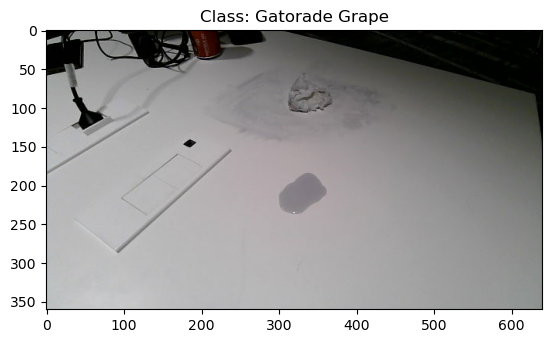

In [13]:
import os
import matplotlib.pyplot as plt
import random
base_folder="LabPictures"
classes = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]
num_classes=len(classes)
for cls in classes:
    class_folder = os.path.join(base_folder, cls)
    randomindex=int(random.random()*num_classes)
    img_name=os.listdir(class_folder)[randomindex]
    image=plt.imread(os.path.join(class_folder, img_name))
    plt.imshow(image)
    plt.title("Class: " + cls)
    plt.show()

## Methodology: Finetuning into the 3 Category Model

Using the data from the lab, the 21 Category model is specialized into a model that identifies 3 of the 21 categories, with images taken under lab conditions.

This is achieved using the following code, which can be seen in the ModelFineTuner.py file.

In [ ]:

import os
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import random
from PIL import Image
import matplotlib.pyplot as plt
"""
This code is similar to the model maker, but instead of tuning a new Resnet50,
It loads the 21CategoryModel state_dict into it, and finetunes 
with the Lab Pictures, into the 3Category Model.
"""



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(0))
base_folder="LabPictures"
classes = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]
num_classes=len(classes)

#I just load image paths and labels from the the root directory
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
idx_to_class = {v: k for k, v in class_to_idx.items()}

image_paths, labels = [], []
for cls in classes:
    class_folder = os.path.join(base_folder, cls)
    for img_name in os.listdir(class_folder):
        if img_name.endswith(".jpg"):
            image_paths.append(os.path.join(class_folder, img_name))
            labels.append(class_to_idx[cls])

OriginalModel = models.resnet50(pretrained=False)

# This is the tricky part. First, I load the state_dict into an object
state_dict = torch.load('21CategoryModel.pth', map_location=device)

# Then I remove final layer weights of the resnet50 model (since we are switching from 21 Categories to 3 Categories)
state_dict.pop('fc.weight', None)
state_dict.pop('fc.bias', None)

# Here I load the state_dict into the model
OriginalModel.load_state_dict(state_dict, strict=False)

# And Replace classifier head for 3-class output
OriginalModel.fc = nn.Linear(OriginalModel.fc.in_features, 3)

OriginalModel.to(device)

# Here I open all the parameters for fine-tuning.
for param in OriginalModel.parameters():
    param.requires_grad = True

""" 
Just like in Assignment 1,
I'll be doing a per-layer learning rate, giving higher learning rates to my later layers, and lower learning rates to my
earlier layers. 
"""
r50layerwise_lrs = {
    "fc": 1e-3,        # Highest learning rate for final layer
    "layer4": 1e-4,    # Moderate learning rate for the last residual block
    "layer3": 5e-5,    # Lower learning rate for mid-level features
    "layer2": 1e-5,    # Even lower learning rate for early mid-level features
    "layer1": 1e-6,    # Very low learning rate for shallow layers (edge/textures)
    "conv1": 1e-7      # Barely moving (keeps basic low-level features intact)
}

# Here I prepare parameter groups for optimizer
r50param_groups = []
for name, param in OriginalModel.named_parameters():
    for layer, lr in r50layerwise_lrs.items():
        if layer in name:
            r50param_groups.append({"params": param, "lr": lr})
            break  # Once assigned to a group, move to the next parameter

# This is my own custom Dataset object, its not too complex since image paths and labels have already been extracted.
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label
    
#transform for the test data
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.Resize(256),                      
    transforms.CenterCrop(224), 
    transforms.ToTensor(),              
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# This transform is for the test and val data, where non of the augmentation should occur, but the images need to be cropped and resized still
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# This just ensures that all data is well represented across all classes and across all 3 sets
def stratified_split(image_paths, labels, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2, seed=42):
    random.seed(seed)
    label_to_indices = {}
    for idx, label in enumerate(labels):
        label_to_indices.setdefault(label, []).append(idx)

    train_idx, val_idx, test_idx = [], [], []

    for label, indices in label_to_indices.items():
        random.shuffle(indices)
        total = len(indices)
        t_end = int(train_ratio * total)
        v_end = t_end + int(val_ratio * total)
        train_idx.extend(indices[:t_end])
        val_idx.extend(indices[t_end:v_end])
        test_idx.extend(indices[v_end:])

    # Use indices to gather data
    train_paths = [image_paths[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]

    val_paths = [image_paths[i] for i in val_idx]
    val_labels = [labels[i] for i in val_idx]

    test_paths = [image_paths[i] for i in test_idx]
    test_labels = [labels[i] for i in test_idx]

    return (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels)

# Split them
(train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels) = stratified_split(image_paths, labels)

# Create dataset objects
train_dataset = ImageDataset(train_paths, train_labels, transform=train_transform)
val_dataset = ImageDataset(val_paths, val_labels, transform=test_transform)  # basic transform if needed
test_dataset = ImageDataset(test_paths, test_labels, transform=test_transform)  # same here

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# I define my loss and learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(r50param_groups)

#Now I train my model's final layer. Originally set at 1000 and rely on early stopping,
num_epochs = 1000

#Here I setup some parameters for early stopping
best_val_loss = float('inf')  # Initialize with a very large value
patience_counter = 0  # Counter for patience
patience = 0  # Patience of 0 epoch
track_loss=[] #for graphing my Loss


for epoch in range(num_epochs):
    OriginalModel.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs =OriginalModel(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    OriginalModel.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    val_loss = 0.0 

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = OriginalModel(images)
            loss = criterion(outputs, labels)  # Compute validation loss
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate the average validation loss
    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")
    track_loss.append(avg_val_loss)
    # Check for improvement in validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss  # Update the best validation loss
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1  # Increment the counter if there's no improvement

    # Early stopping check
    if patience_counter > patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break  # Stop training

    # I keep getting Out of Memory issues so I need to clear somethings every epoch.
    del images, labels, outputs, loss, predicted
    torch.cuda.empty_cache()
#Testing Phase for Transfer Learning ResNet Model
plt.plot(range(len(track_loss)),track_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss for Our Model (3 Categories Fine Tuned)")
plt.savefig("3CategoriesLoss.png")

torch.save(OriginalModel.state_dict(), "3FineCategoryModel.pth")
print("Model Saved!")

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = OriginalModel(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    del images, labels, outputs, predicted
    torch.cuda.empty_cache()

accuracy = 100 * correct / total
print(f"Test Accuracy for Transfer Learning: {accuracy:.2f}%")

### Discussion

Noteable features of this code are as follows:

1) Since the 21 Category Model pth file only contains the weight value, the state_dict file from it is directly incorporated into a Resnet50 model structure with no weights. This was achieved using the following code lines:

In [ ]:
OriginalModel = models.resnet50(pretrained=False)

# This is the tricky part. First, I load the state_dict into an object
state_dict = torch.load('21CategoryModel.pth', map_location=device)

OriginalModel.load_state_dict(state_dict, strict=False)

2) The final classification layer is swapped out, from a 21 neuron layer into a 3 nueron layer, in the code lines below.

In [ ]:
state_dict.pop('fc.weight', None)
state_dict.pop('fc.bias', None)

# And Replace classifier head for 3-class output
OriginalModel.fc = nn.Linear(OriginalModel.fc.in_features, 3)

3) The same transformation and data augmentations were applied to this set as the main model, for better performance.

# Methodology: Testing for Both Models

Both the 21CategoryModel and the 3CategoryModel were tested with the images taken from the lab. This was achieved by the following code, where the  state_dict object's code was changed to refer to whichever model was being tested. This code can also be seen in the TestModel.py file:

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import random
from PIL import Image
# Once again I show my torch cuda device. Proof that my gaming GPU is not just for gaming
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(0))


# Here I just prep my data as image paths and respective labels
base_folder="LabPictures"
classes = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]
num_classes=len(classes)
print(classes)
#I just load image paths and labels from the the root directory
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
idx_to_class = {v: k for k, v in class_to_idx.items()}

image_paths, labels = [], []
for cls in classes:
    class_folder = os.path.join(base_folder, cls)
    for img_name in os.listdir(class_folder):
        if img_name.endswith(".jpg"):
            image_paths.append(os.path.join(class_folder, img_name))
            labels.append(class_to_idx[cls])

TestModel = models.resnet50(pretrained=False)
TestModel.fc = nn.Linear(TestModel.fc.in_features, 21) #<---if training the 3Category Model, this is commented out

state_dict = torch.load('21FineCategoryModel.pth', map_location=device) # we use '3FineCategoryModel.pth' when training 3Category Model

TestModel.load_state_dict(state_dict,strict=False)

TestModel.to(device)

# This is my own custom Dataset object, its not too complex since image paths and labels have already been extracted.
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label
    
#transform for the test data
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# This transform is for the test and val data, where non of the augmentation should occur, but the images need to be cropped and resized still
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])
# Create dataset objects
dataset = ImageDataset(image_paths, labels, transform=test_transform)

# Dataloaders
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)
TestModel.eval()  # Set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = TestModel(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    del images, labels, outputs, predicted
    torch.cuda.empty_cache()

accuracy = 100 * correct / total
print(f"Test Accuracy for 21 Category Model on Lab Images: {accuracy:.2f}%")

**Discussion:** The Tricky section here is how the model is loaded. When loading the 21Category model, this section of code looks like:

In [ ]:
TestModel = models.resnet50(pretrained=False)
TestModel.fc = nn.Linear(TestModel.fc.in_features, 21) #<---if training the 3Category Model, this is uncommented

state_dict = torch.load('21CategoryModel.pth', map_location=device) # we use '3FineCategoryModel.pth' when training 3Category Model

# Here I load the state_dict into the model
TestModel.load_state_dict(state_dict,strict=False)

TestModel.to(device)

If it was the 3 Category Model being tested, this part looks like:

In [ ]:
TestModel = models.resnet50(pretrained=False)
TestModel.fc = nn.Linear(TestModel.fc.in_features, 3) #<---if training the 3Category Model, this is uncommented

state_dict = torch.load('3FineCategoryModel.pth', map_location=device) # we use '3FineCategoryModel.pth' when training 3Category Model

# Here I load the state_dict into the model
TestModel.load_state_dict(state_dict,strict=False)

TestModel.to(device)

# Methodology: Robot Implementation

Once the 3 Category Model was obtained, the model was implemented into the robot. This model was accessed using the following subscriber code. This can also be seen in the react.py file:

In [ ]:
import os
import rclpy
from rclpy.node import Node
from sensor_msgs.msg import Image
from geometry_msgs.msg import Twist
from cv_bridge import CvBridge
import cv2
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import models
import PIL.Image as PIL_Image

class VisionMover(Node):
    def __init__(self):
        super().__init__('vision_mover')
        self.cam_subscription = self.create_subscription(Image, '/depth_cam/rgb/image_raw', self.image_callback, 1)
        self.cv_bridge = CvBridge()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.latest_image = None

        # Publisher for movement
        self.cmd_vel_pub = self.create_publisher(Twist, '/cmd_vel', 10)

        # Paths to model and class labels (update these paths as needed)
        self.model_path = '/home/ubuntu/48288209/comp8430_week12/src/react_topic/react_topic/3FineCategoryModel.pth'
        self.class_labels_path = '/home/ubuntu/48288209/comp8430_week12/src/react_topic/react_topic/class_labels.txt'

        # Load class labels
        try:
            with open(self.class_labels_path, "r") as f:
                self.class_labels = [line.strip() for line in f.readlines()]
            self.get_logger().info(f"Loaded {len(self.class_labels)} class labels.")
        except Exception as e:
            self.get_logger().error(f"Failed to load class labels: {e}")
            self.class_labels = [f"Class {i+1}" for i in range(3)]  # fallback

        # Load model
        model = models.resnet50(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, len(self.class_labels))
        # The problem last time is that the pth was saved as state_dict, not the actual model. I addressed that here
        try:
            state_dict = torch.load(self.model_path, map_location=self.device)
            model.load_state_dict(state_dict)
            self.get_logger().info(f"Model loaded from {self.model_path}")
        except Exception as e:
            self.get_logger().error(f"Failed to load model: {e}")

        model.to(self.device).eval()
        self.model = model

        # Image preprocessing pipeline
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        #I only want the robot to take a photo once per second. Gives us a lot of time to react if something happens 
        self.timer = self.create_timer(1.0, self.process_image)

    def image_callback(self, msg):
        try:
            img_bgr = self.cv_bridge.imgmsg_to_cv2(msg, "bgr8")
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            self.latest_image = img_rgb
        except Exception as e:
            self.get_logger().warn(f"Image conversion failed: {e}")

    def process_image(self):
        if self.latest_image is None:
            self.get_logger().warn("No image received yet.")
            return

        # Preprocess and classify
        try:
            input_tensor = self.transform(self.latest_image).unsqueeze(0).to(self.device)
        except Exception as e:
            self.get_logger().warn(f"Image transform failed: {e}")
            return

        with torch.no_grad():
            output = self.model(input_tensor)
            probs = torch.softmax(output, dim=1).squeeze()

        max_prob = torch.max(probs).item()
        predicted_idx = torch.argmax(probs).item()
        predicted_label = self.class_labels[predicted_idx] if predicted_idx < len(self.class_labels) else f"Class {predicted_idx+1}"

        # This is where the classfication result is logged
        if max_prob < 0.75:
            self.get_logger().info(f"Uncertain classification (max prob: {max_prob:.2f}). Staying still.")
            linear_x, angular_z = 0.0, 0.0
        else:
            self.get_logger().info(f"Classified as '{predicted_label}' with confidence {max_prob:.2f}")
            # This is where the movement is decided based on the class
            if predicted_idx == 0:
                linear_x, angular_z = 0.2, 0.0
            elif predicted_idx == 1:
                linear_x, angular_z = 0.2, 1.0
            elif predicted_idx == 2:
                linear_x, angular_z = -0.2, 0.0
            else:
                linear_x, angular_z = 0.0, 0.0
                self.get_logger().warn("Invalid class detected. Stopping.")

        twist = Twist()
        twist.linear.x = linear_x
        twist.angular.z = angular_z
        self.cmd_vel_pub.publish(twist)

        # I want to see visually how the robot sees the spills
        try:
            img_bgr = cv2.cvtColor(self.latest_image, cv2.COLOR_RGB2BGR)
            img_with_label = self.plot_cls_labels(img_bgr, f"{predicted_label}: {max_prob:.2f}")
            cv2.imshow("Classification Results", img_with_label)
            cv2.waitKey(1)
        except Exception as e:
            self.get_logger().warn(f"Failed to display image: {e}")

    def plot_cls_labels(self, img, cls_text, box_color=(0, 255, 0), text_color=(0, 0, 0)):
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.6
        thickness = 1
        margin = 5
        (text_w, text_h), _ = cv2.getTextSize(cls_text, font, font_scale, thickness)
        top_left = (margin, margin)
        bottom_right = (margin + text_w + 2 * margin, margin + text_h + 2 * margin)
        cv2.rectangle(img, top_left, bottom_right, box_color, thickness=-1)
        text_origin = (top_left[0] + margin, top_left[1] + text_h + margin // 2)
        cv2.putText(img, cls_text, text_origin, font, font_scale, text_color, thickness, lineType=cv2.LINE_AA)
        return img


def main(args=None):
    rclpy.init(args=args)
    node = VisionMover()
    try:
        rclpy.spin(node)
    except KeyboardInterrupt:
        print("Shutting down...")
    node.destroy_node()
    rclpy.shutdown()

if __name__ == '__main__':
    main()

### Discussion: Robot Implmenetation

Noteable features of this code are as follows:

1) I manually set a timer for the robot to only process one image per second. This allows us to react should the robot decide to behave poorly. The images of spills cannot be taken on the carpeted floor, thus, the needed to have the robot move on the table. This timer gives us some reaction leeway if the robot moves off the edge of the table. The implmentation is in the code snippet below:

In [ ]:
#I only want the robot to take a photo once per second. Gives us a lot of time to react if something happens 
self.timer = self.create_timer(1.0, self.process_image)

2) Depending on what spill the robot sees, the robot was coded to move as follows:  
Coke -> Forward  
Blue Gatorade -> Forward + Turn  
Gatorade Red -> Backward  
Uncertain -> Stop  

This was implemented in the following part of the code:

In [ ]:
        # This is where the classfication result is logged
        if max_prob < 0.5:
            self.get_logger().info(f"Uncertain classification (max prob: {max_prob:.2f}). Staying still.")
            linear_x, angular_z = 0.0, 0.0
        else:
            self.get_logger().info(f"Classified as '{predicted_label}' with confidence {max_prob:.2f}")
            # This is where the movement is decided based on the class
            if predicted_idx == 0:
                linear_x, angular_z = 0.2, 0.0
            elif predicted_idx == 1:
                linear_x, angular_z = 0.2, 1.0
            elif predicted_idx == 2:
                linear_x, angular_z = -0.2, 0.0
            else:
                linear_x, angular_z = 0.0, 0.0
                self.get_logger().warn("Invalid class detected. Stopping.")

        twist = Twist()
        twist.linear.x = linear_x
        twist.angular.z = angular_z
        self.cmd_vel_pub.publish(twist)


3) Some debugging code allows us to see what the robot sees, and what class the robot classifies the images of its vision as. This was implemented in the following lines:

In [ ]:
   # I want to see visually how the robot sees the spills
        try:
            img_bgr = cv2.cvtColor(self.latest_image, cv2.COLOR_RGB2BGR)
            img_with_label = self.plot_cls_labels(img_bgr, f"{predicted_label}: {max_prob:.2f}")
            cv2.imshow("Classification Results", img_with_label)
            cv2.waitKey(1)
        except Exception as e:
            self.get_logger().warn(f"Failed to display image: {e}")

    def plot_cls_labels(self, img, cls_text, box_color=(0, 255, 0), text_color=(0, 0, 0)):
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.6
        thickness = 1
        margin = 5
        (text_w, text_h), _ = cv2.getTextSize(cls_text, font, font_scale, thickness)
        top_left = (margin, margin)
        bottom_right = (margin + text_w + 2 * margin, margin + text_h + 2 * margin)
        cv2.rectangle(img, top_left, bottom_right, box_color, thickness=-1)
        text_origin = (top_left[0] + margin, top_left[1] + text_h + margin // 2)
        cv2.putText(img, cls_text, text_origin, font, font_scale, text_color, thickness, lineType=cv2.LINE_AA)
        return img


# Results: 21 Category Model

The Loss of the 21 Category model is shown below:

In [26]:
Image(filename='21CategoriesLoss.png')

The model showed a significant dip in loss on the second epoch (count is made 0,1,2 etc) but an increase is immediately observed in right after.

This kind of behaviour is expected because of 2 things:

1) This is not a model learning from scratch. The Resnet50 model has been trained with image recognition, and likely retains its skills in edge analysis, and color-object identification.

2) The data is designed to be very confusing. As mentioned before, the classes were chosen to be as confusing as possible in order to see the limits of the pre-trained, fine-tuned model, and to observe the performance of the model with additional features in data analysis such as data augmentation and layerwise finetuning.

Because of these, the model learns the base idea of the data, but immediately goes into overfitting the data, because some images are just generally misleading.

The accuracy that the model had for phase 2 averaged around 62.3%.

As a side note: the performance of this model in Phase 2 without data augmentation nor fine-tuning is 13.8%. This means that the model training is significantly improved by data augmentation and layer-wise learning rates.

With the images taken from the Lab, the model's performance drops down to 51.4%. This drop is likely due to the model being affected by the noise from the confusing data it was originally trained on, and because it is trying to classify the images into 21 different classes, even though each image only fits into 3 of the categories that it knows.

These performance levels are still impressive compared to a randomly guessing model that would average its performance at 4.76%.

# Results: 3 Category Model

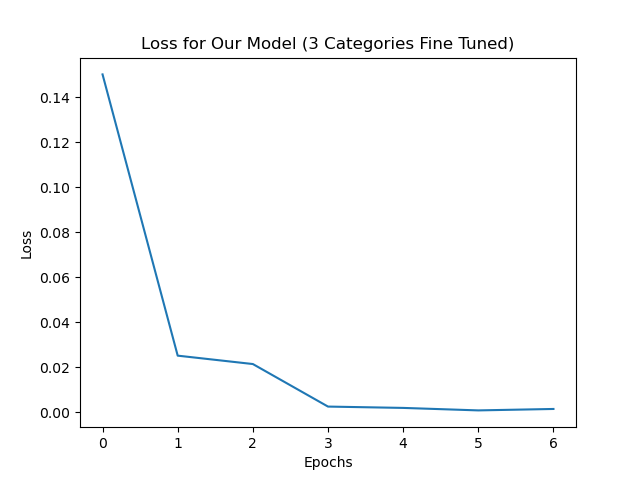

In [24]:
Image(filename='3CategoriesLoss.png')

The model shows a decent loss function with the easier dataset. Since the differences between each class is alot more straightforward, the mistakes of the model are fairly minimal after it has learned the rules.

This is reflected in the validation and testing performance: throughout the training, the model performed with 100% accuracy in validation data, and the final testing phase showed 100% accuracy for the testing data.

This is an acceptable resulting model, and it was crucial in having the robot behave perfectly during implementation.

# Results: Robot Behaviour

The robot's behaviour can be viewed in the RobotBehavior.mp4 file. As shown in that video, the robot is able to react appropriately to the spills it is presented, signalling successful training and implementation of the model to an acting robot.

# Improvements and Recommendations

The project shows that, when it comes to liquids that look identical, other forms of imaging might be needed.
Our recommendations are as follows:

1) Thermal Imaging (Temperature based imaging)
2) Spectrometry Imaging (reflectance based imaging)
3) Video-based Observation (watching liquid's movement over time, while being touched etc.)


This also means that this feature is a lot more expensive than initially expected; if visual imaging and AI isn't enough to perfectly identify domestic spills, these additional imaging data streams need to be added to the AI's input data, for it to be able to identify the spills better.

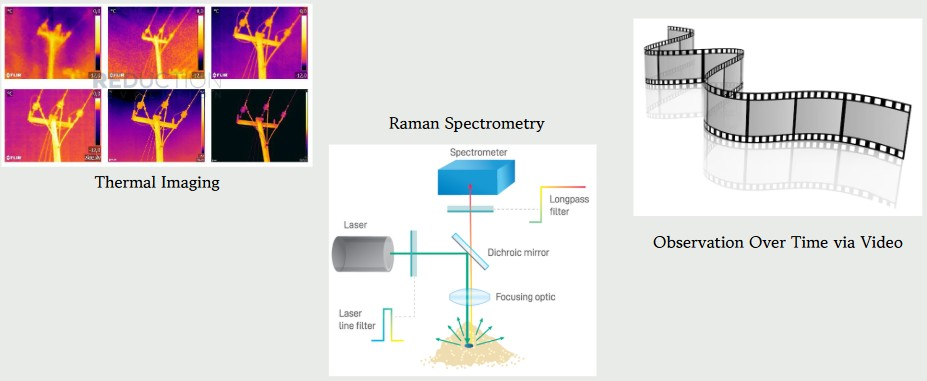

In [25]:
Image(filename='Improvements.jpg')

However, the resulting 3 Category Model does give some hope: if the liquids are differentiable enough, the model can perform with 100% accuracy. Perhaps with more data, or more complex AI architectures, and a little bit more research budget, a visual-only AI imaging system can achieve better results.

Another recommended improvement to the process is the use of a learning rate scheduler, on top of (or in favor over) the layer-wise learning rates. This scheduler could potentially address the early erratic behaviour of the 21 Category Model, however, in practice, the layer-wise learning rates resulted in a higher performance in less time.

Perhaps in another set up with another AI Architecture, learning rate schedulers could work even better than layer-wise.

**Bibliography**  
Jha, M., Levy, J., & Gao, Y. (2008). Advances in Remote Sensing for Oil Spill Disaster Management: State-of-the-Art Sensors Technology for Oil Spill Surveillance. Sensors, 8(1), 236–255. https://doi.org/10.3390/s8010236  

Nirupama, G. (2024). Advances in Forensic Bloodstain Pattern Analysis: A Review of Current Methods and Future Directions. 11. https://ijirt.org/publishedpaper/IJIRT168938_PAPER.pdf 

Tysiąc, P., Strelets, T., & Tuszyńska, W. (2022). The Application of Satellite Image Analysis in Oil Spill Detection. Applied Sciences, 12(8), 4016. https://doi.org/10.3390/app12084016
